In [15]:
!pip install allennlp wordcloud imblearn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
import warnings
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Concatenate, Reshape
from tensorflow.keras.models import Model
import tensorflow_hub as hub
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tokenizers import Tokenizer, models, pre_tokenizers, trainers

nltk.download('punkt')
nltk.download('stopwords')
warnings.filterwarnings("ignore")

### Basic Data description

In [2]:
dataset = pd.read_csv('final_cleaned_dataset.csv')
print("First 5 rows of the dataset:")
print(dataset.head())
print("\nShape of the dataset:", dataset.shape)
print("\nColumn names:", dataset.columns)
print("\nData types:\n", dataset.dtypes)
print("\nMissing values:\n", dataset.isnull().sum())
dataset.dropna(inplace=True)

First 5 rows of the dataset:
                                             Content  Label  \
0  denial of normal the con be asked to comment o...      1   
1  just by being able to tweet this insufferable ...      1   
2  that is retarded you too cute to be single tha...      1   
3  thought of a real badass mongol style declarat...      1   
4                                afro american basho      1   

                                         Content_int  
0  [146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,...  
1  [146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22...  
2  [146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,...  
3  [146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,...  
4                       [146715, 46, 47, 48, 146714]  

Shape of the dataset: (440899, 3)

Column names: Index(['Content', 'Label', 'Content_int'], dtype='object')

Data types:
 Content        object
Label           int64
Content_int    object
dtype: object

Missing values:
 Content        0
Label          0
Content

### Class Distribution

Distribution of Target Variable:
0    361594
1     79305
Name: Label, dtype: int64


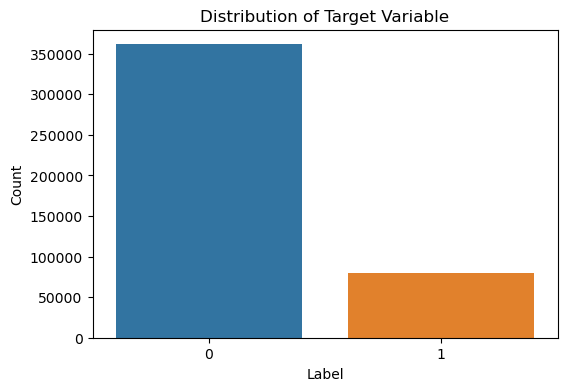

In [18]:
label_counts = dataset['Label'].value_counts()
print("Distribution of Target Variable:")
print(label_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=dataset)
plt.title('Distribution of Target Variable')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

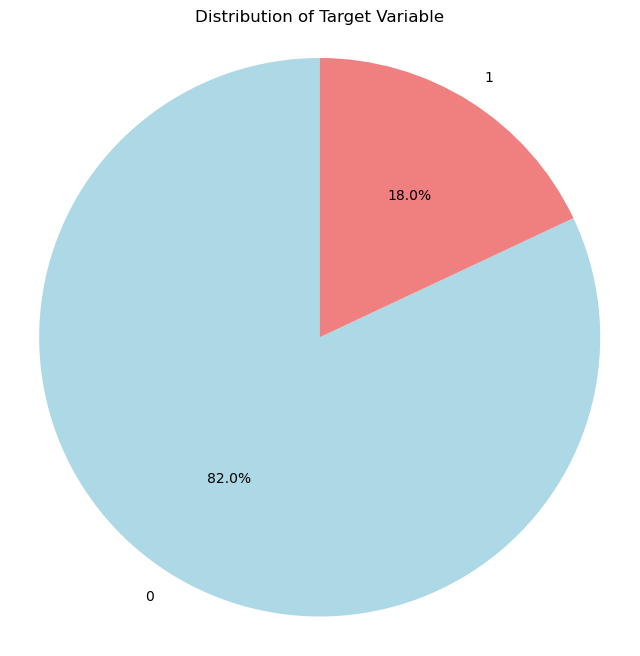

In [19]:
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Distribution of Target Variable')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

### Balancing Class

In [20]:
X = dataset['Content']
y = dataset['Label']

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Perform random undersampling
X_resampled, y_resampled = rus.fit_resample(X.values.reshape(-1, 1), y)

# Convert back to DataFrame (if needed)
df_resampled = pd.DataFrame({'Content': X_resampled.flatten(), 'Label': y_resampled})

# Display the balanced dataset
print("Balanced Dataset:")
print(df_resampled)

Balanced Dataset:
                                                  Content  Label
0                retweet these bitches is actors out here      0
1       fatima bit sad i noticed you added a large chu...      0
2       travelling to bhubaneswar for the movies findi...      0
3       i am a huge fan of those misogynists that stil...      0
4       this is a seriously inadequate list if it is m...      0
...                                                   ...    ...
158605                      eat my shit title says it all      1
158606  not the same person stop changing it to your o...      1
158607  anal sex i am gay and actively engage in anal ...      1
158608  vandalism please stop if you continue to vanda...      1
158609  you bet your ass it is inappropriate whatever ...      1

[158610 rows x 2 columns]


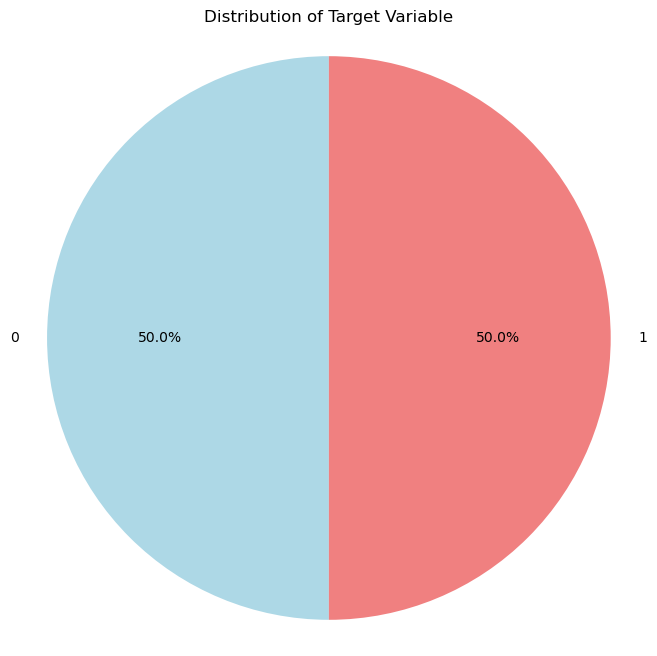

In [21]:
dataset = df_resampled
label_counts = dataset['Label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Distribution of Target Variable')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

### Text length analysis

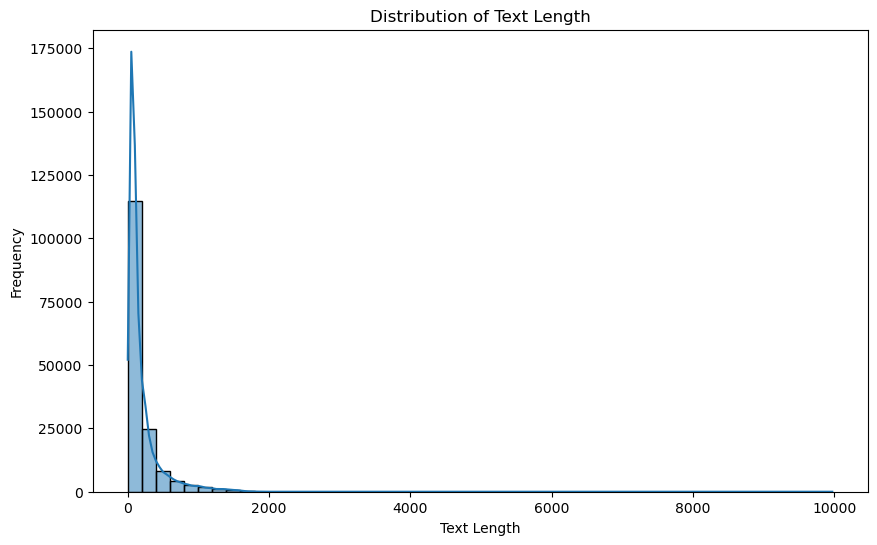

In [22]:
# Length of text entries
dataset['text_length'] = dataset['Content'].apply(len)

# Plot the distribution of text length
plt.figure(figsize=(10, 6))
sns.histplot(dataset['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [23]:
print(dataset['text_length'].describe())

count    158610.000000
mean        192.478141
std         249.817574
min           1.000000
25%          56.000000
50%         104.000000
75%         220.000000
max        9969.000000
Name: text_length, dtype: float64


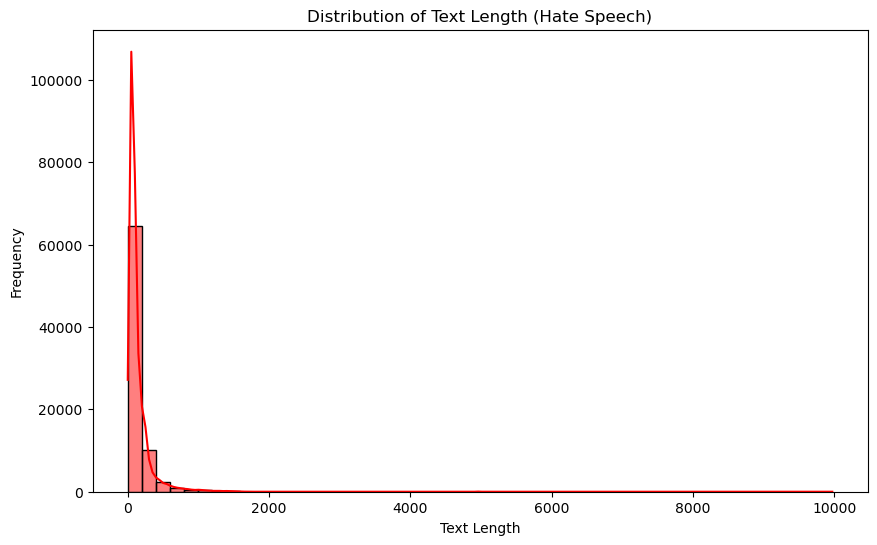

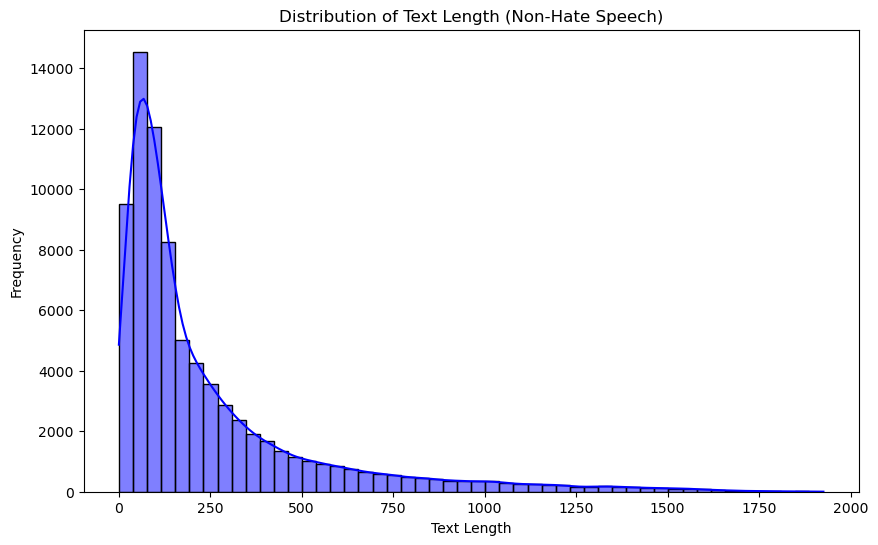

In [24]:
hate_speech = dataset[dataset['Label'] == 1]
non_hate_speech = dataset[dataset['Label'] == 0]

# Plot the distribution of text length for hate speech
plt.figure(figsize=(10, 6))
sns.histplot(hate_speech['text_length'], bins=50, kde=True, color='red')
plt.title('Distribution of Text Length (Hate Speech)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of text length for non-hate speech
plt.figure(figsize=(10, 6))
sns.histplot(non_hate_speech['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Text Length (Non-Hate Speech)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [25]:
# Drop rows where the word count exceeds 1000
dataset = dataset[dataset['text_length'] <= 1000]

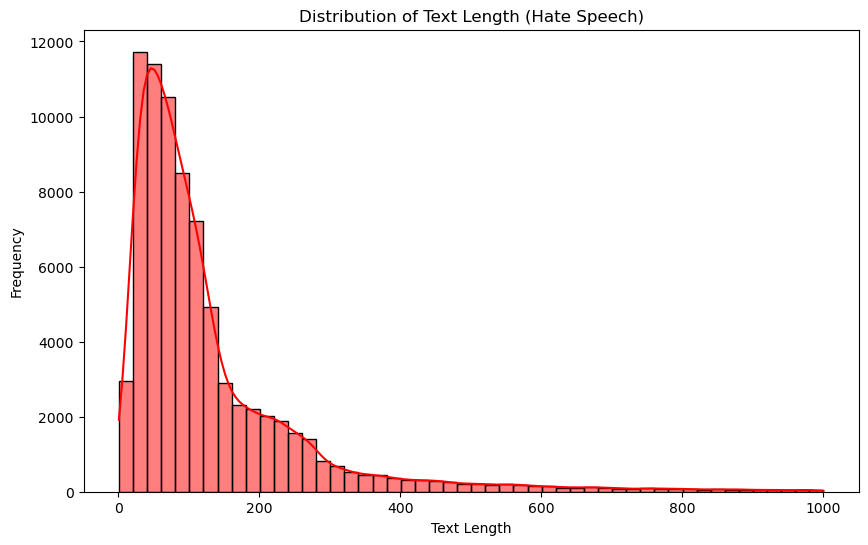

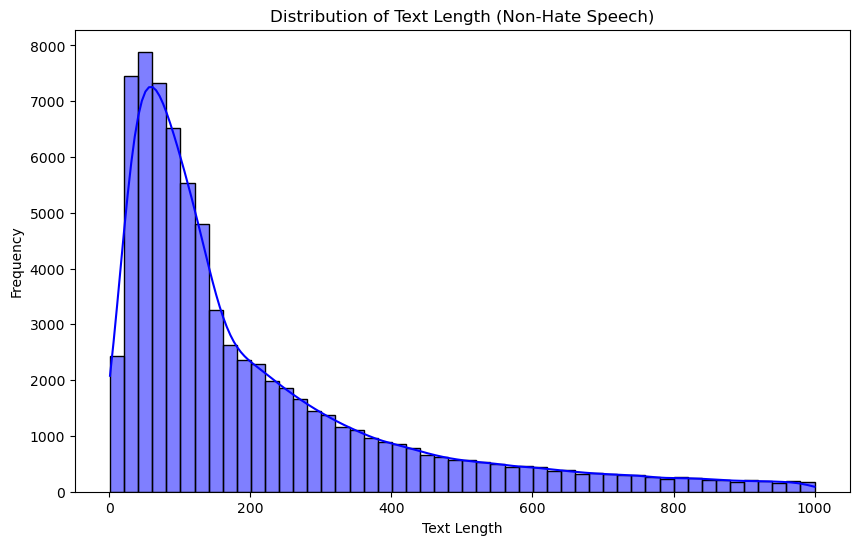

In [26]:
hate_speech = dataset[dataset['Label'] == 1]
non_hate_speech = dataset[dataset['Label'] == 0]

# Plot the distribution of text length for hate speech
plt.figure(figsize=(10, 6))
sns.histplot(hate_speech['text_length'], bins=50, kde=True, color='red')
plt.title('Distribution of Text Length (Hate Speech)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of text length for non-hate speech
plt.figure(figsize=(10, 6))
sns.histplot(non_hate_speech['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Text Length (Non-Hate Speech)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

### Frequent Words analysis

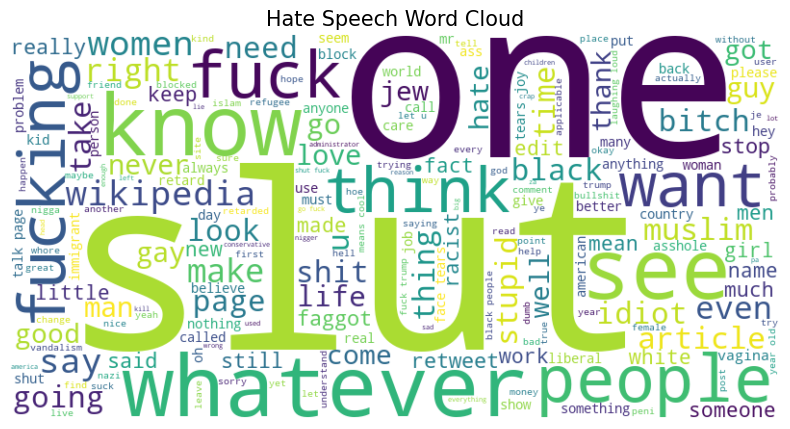

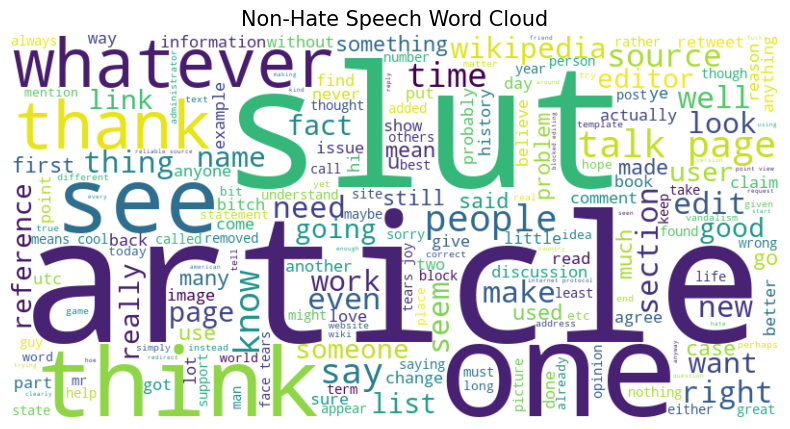

In [27]:
# Preprocess the text data
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

dataset['cleaned_text'] = dataset['Content'].apply(preprocess_text)

# Separate hate and non-hate speech
hate_speech = dataset[dataset['Label'] == 1]['cleaned_text']
non_hate_speech = dataset[dataset['Label'] == 0]['cleaned_text']

# Generate Word Clouds
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

generate_word_cloud(hate_speech, 'Hate Speech Word Cloud')
generate_word_cloud(non_hate_speech, 'Non-Hate Speech Word Cloud')

### Bi gram analysis

In [28]:
# Function to get top n-grams
def get_top_ngrams(corpus, ngram_range=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top bigrams
top_bigrams_hate = get_top_ngrams(hate_speech, n=20)
top_bigrams_non_hate = get_top_ngrams(non_hate_speech, n=20)

print('Top Bigrams in Hate Speech:')
print(top_bigrams_hate)
print('\nTop Bigrams in Non-Hate Speech:')
print(top_bigrams_non_hate)

Top Bigrams in Hate Speech:
[('tears joy', 803), ('talk page', 769), ('face tears', 762), ('laughing loud', 694), ('black people', 688), ('year old', 570), ('means cool', 569), ('fuck trump', 553), ('shut fuck', 480), ('retweet sexist', 476), ('piece shit', 466), ('fuck fuck', 428), ('gun control', 391), ('joy face', 378), ('nigger nigger', 374), ('united states', 367), ('internet protocol', 357), ('people like', 353), ('look like', 352), ('ching chong', 342)]

Top Bigrams in Non-Hate Speech:
[('talk page', 3218), ('means cool', 964), ('tears joy', 956), ('face tears', 942), ('internet protocol', 777), ('point view', 757), ('blocked editing', 720), ('laughing loud', 628), ('feel free', 603), ('user page', 599), ('let know', 597), ('talk pages', 525), ('speedy deletion', 515), ('joy face', 491), ('united states', 470), ('happy face', 466), ('face smiley', 466), ('fair use', 446), ('editing wikipedia', 434), ('reliable sources', 433)]


### Unique words and Diversity of words

In [29]:

def unique_words(text):
    words = word_tokenize(' '.join(text))
    return len(set(words))

# Calculate unique words for hate and non-hate speech
unique_words_hate = unique_words(hate_speech)
unique_words_non_hate = unique_words(non_hate_speech)

print(f'Unique words in hate speech: {unique_words_hate}')
print(f'Unique words in non-hate speech: {unique_words_non_hate}')

# Add a column for word count
dataset['word_count'] = dataset['Content'].apply(lambda x: len(word_tokenize(x))) 

# Calculate vocabulary diversity (unique words / total words)
vocab_diversity_hate = unique_words_hate / sum(dataset[dataset['Label'] == 1]['word_count'])
vocab_diversity_non_hate = unique_words_non_hate / sum(dataset[dataset['Label'] == 0]['word_count'])

print(f'Vocabulary diversity in hate speech: {vocab_diversity_hate:.4f}')
print(f'Vocabulary diversity in non-hate speech: {vocab_diversity_non_hate:.4f}')

Unique words in hate speech: 48873
Unique words in non-hate speech: 59822
Vocabulary diversity in hate speech: 0.0253
Vocabulary diversity in non-hate speech: 0.0208


### Feature Extraction.

#### BPE

In [1]:

# Step 1: Load the CSV file
file_path = 'final_cleaned_dataset.csv'
df = pd.read_csv(file_path)
df['Content'] = df['Content'].astype(str).fillna('')

# Step 2: Apply BPE
# Create a BPE tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Train the tokenizer on the "Content" column
trainer = trainers.BpeTrainer(vocab_size=5000, special_tokens=["<pad>", "<unk>", "<s>", "</s>"])
tokenizer.train_from_iterator(df["Content"].tolist(), trainer=trainer)

# Encode the content using the trained tokenizer
df["Encoded_Content"] = df["Content"].apply(lambda x: tokenizer.encode(x).tokens)

# Step 3: Display the encoded values
print(df[["Content", "Encoded_Content"]].head())

                                             Content  \
0  denial of normal the con be asked to comment o...   
1  just by being able to tweet this insufferable ...   
2  that is retarded you too cute to be single tha...   
3  thought of a real badass mongol style declarat...   
4                                afro american basho   

                                     Encoded_Content  
0  [denial, of, normal, the, con, be, asked, to, ...  
1  [just, by, being, able, to, tweet, this, in, s...  
2  [that, is, retarded, you, too, cute, to, be, s...  
3  [thought, of, a, real, bad, ass, mongo, l, sty...  
4                          [afro, american, bas, ho]  


In [2]:
df.to_csv('preprocessed.csv',index=False)

In [14]:
# Step 1: Load the CSV file
file_path = 'final_cleaned_dataset.csv'
df = pd.read_csv(file_path)
df['Content'] = df['Content'].astype(str).fillna('')

# Step 2: Load the pre-trained ELMo model from TensorFlow Hub
elmo = hub.load("https://tfhub.dev/google/elmo/3")

# Step 3: Embed the text using ELMo
def elmo_embeddings(text):
    return elmo.signatures['default'](tf.constant([text]))['elmo'][0]

# Compute and display ELMo embeddings for the first few entries
for index, text in enumerate(df['Content'].head()):
    embedding = elmo_embeddings(text).numpy()
    print(f"Embedding for content at index {index}:\n", embedding)
    print("\n")


Embedding for content at index 0:
 [[-0.05756496 -0.19989365  0.97542197 ...  0.26165226  0.773973
   0.13465525]
 [ 0.04955727 -0.07659417 -0.48638755 ... -1.4874458   0.20078118
  -0.18183102]
 [ 0.0253429  -0.06267571 -0.40475833 ... -0.0873818   0.43387216
  -0.20997165]
 ...
 [-0.04049957 -0.10336779 -0.22992872 ...  0.23122981  0.13595799
  -0.04609063]
 [-0.35114536 -0.4311973  -0.39144808 ...  0.1746355   0.57948756
  -0.02373713]
 [-0.06676174 -0.37792614  0.44010383 ...  0.29187104  0.30248162
   0.13895375]]


Embedding for content at index 1:
 [[-0.17679305  0.7695161   0.8578844  ... -0.4968834  -0.06975698
   0.14518237]
 [ 0.18202916  0.22514015 -0.23299372 ... -0.19965874  0.13324916
   0.37895364]
 [ 0.13119371  0.06772238 -0.05922202 ... -0.56531864  0.51680815
  -0.11041923]
 ...
 [-0.3009447  -0.7280244   0.45428404 ... -0.30096424  0.5851779
  -0.3306596 ]
 [-0.6992409  -0.3348759   0.00108742 ...  0.15327121  0.10041791
  -0.243003  ]
 [-0.426546   -0.07134275  0.

### LSTM

In [32]:
# Load and preprocess the data
data = pd.read_csv('final_cleaned_dataset.csv')
data['Content'] = data['Content'].astype(str).fillna('')
texts = data['Content'].values
labels = data['Label'].values

# Tokenize and pad the sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=200)

# Calculate the size of each set
train_size = int(0.8 * len(padded_sequences))
val_size = int(0.1 * len(padded_sequences))
test_size = len(padded_sequences) - train_size - val_size

# Split the data
x_train = padded_sequences[:train_size]
y_train = labels[:train_size]

x_val = padded_sequences[train_size:train_size + val_size]
y_val = labels[train_size:train_size + val_size]

x_test = padded_sequences[train_size + val_size:]
y_test = labels[train_size + val_size:]

In [59]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=200))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
11023/11023 [==============================] - 324s 32ms/step - loss: 0.4289 - accuracy: 0.7809 - val_loss: 0.4133 - val_accuracy: 0.7984
Epoch 2/10
11023/11023 [==============================] - 324s 32ms/step - loss: 0.4108 - accuracy: 0.7992 - val_loss: 0.3871 - val_accuracy: 0.8411
Epoch 3/10
11023/11023 [==============================] - 324s 32ms/step - loss: 0.3759 - accuracy: 0.8290 - val_loss: 0.3231 - val_accuracy: 0.8684
Epoch 4/10
11023/11023 [==============================] - 324s 32ms/step - loss: 0.3291 - accuracy: 0.8489 - val_loss: 0.2998 - val_accuracy: 0.8440
Epoch 5/10
11023/11023 [==============================] - 324s 32ms/step - loss: 0.2921 - accuracy: 0.8837 - val_loss: 0.2554 - val_accuracy: 0.8867
Epoch 6/10
11023/11023 [==============================] - 324s 32ms/step - loss: 0.2612 - accuracy: 0.8605 - val_loss: 0.2178 - val_accuracy: 0.8838
Epoch 7/10
11023/11023 [==============================] - 324s 32ms/step - loss: 0.1968 - accuracy: 0.9018

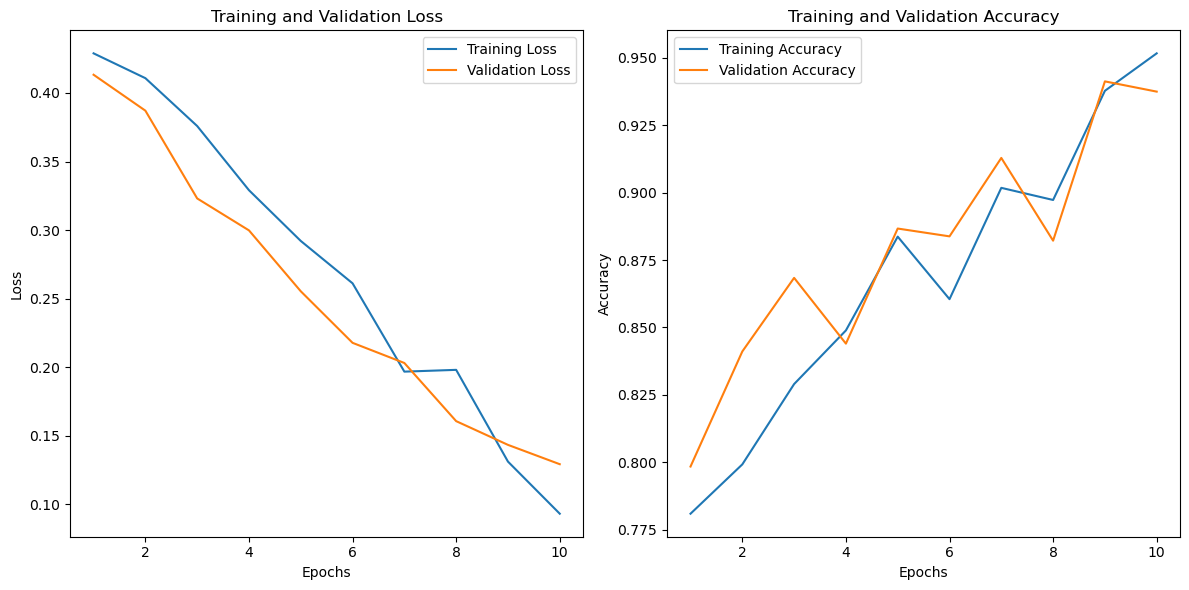

In [60]:

# Extract training history
history_dict = history.history

# Plot training & validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
loss, accuracy = model.evaluate(x_test,y_test)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Loss: 0.1293
Accuracy: 0.9037


### LLM model

In [100]:
# Load and preprocess the data
data = pd.read_csv('final_cleaned_dataset.csv')
data['Content'] = data['Content'].astype(str).fillna('')
texts = data['Content'].values
labels = data['Label'].values
texts = texts.tolist()
labels = labels.tolist()

x_temp, x_test, y_temp, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
x_train_texts, x_val_texts, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='tf')

train_encodings = tokenize_texts(x_train_texts)
val_encodings = tokenize_texts(x_val_texts)
test_encodings = tokenize_texts(x_test)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_val))

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(16)
val_dataset = val_dataset.batch(16)
test_dataset = val_dataset.batch(16)

In [63]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.2307 - accuracy: 0.9091 - val_loss: 0.2986 - val_accuracy: 0.8971
Epoch 2/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.2557 - accuracy: 0.9208 - val_loss: 0.2629 - val_accuracy: 0.8576
Epoch 3/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.1949 - accuracy: 0.8277 - val_loss: 0.2605 - val_accuracy: 0.8633
Epoch 4/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.1762 - accuracy: 0.8525 - val_loss: 0.2368 - val_accuracy: 0.8869
Epoch 5/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.1841 - accuracy: 0.8881 - val_loss: 0.2018 - val_accuracy: 0.9595
Epoch 6/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.1783 - accuracy: 0.9646 - val_loss: 0.1638 - val_accuracy: 0.9007
Epoch 7/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.1760 - accuracy: 0.8852

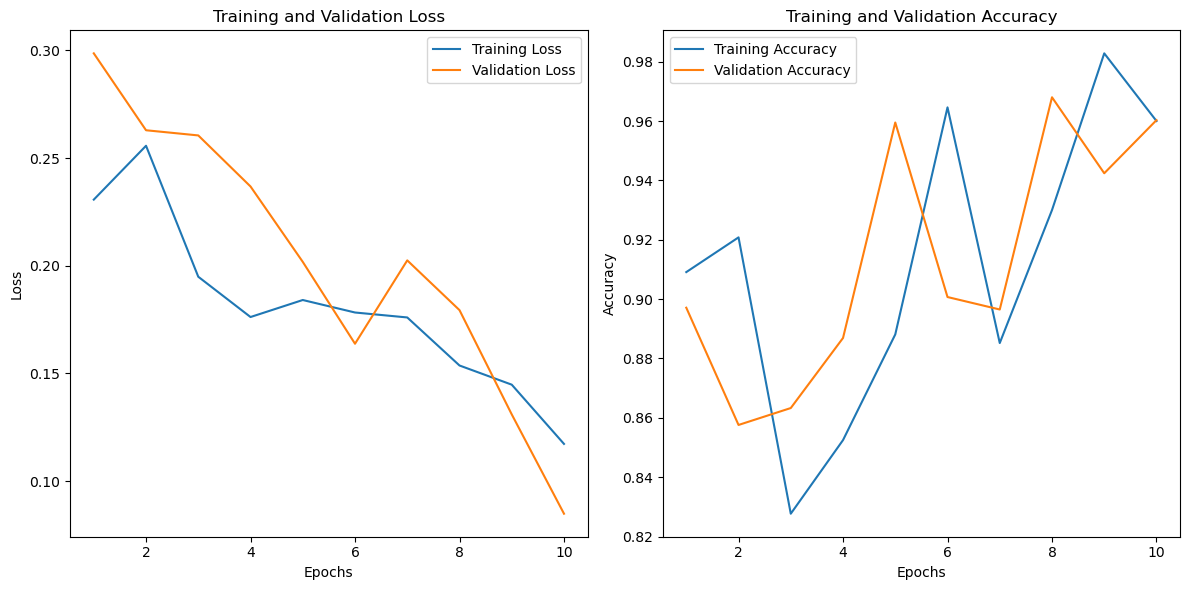

In [64]:
history_dict = history.history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Loss: 0.0826
Accuracy: 0.9603


### LSTM with preprocessing

In [14]:
# Load your data
df = pd.read_csv('preprocessed.csv')

# Convert lists to strings
df['Encoded_Content'] = df['Encoded_Content'].apply(lambda x: ' '.join(eval(x)))
df['Encoded_Content'] = df['Encoded_Content'].astype(str).fillna(' ')

X = df['Encoded_Content'].values
y = df['Label'].values

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [48]:
# Ensure TensorFlow's eager execution is enabled
tf.config.run_functions_eagerly(True)

# Define the model
input_text = Input(shape=(), dtype=tf.string, name='input_text')
elmo_layer = hub.KerasLayer("https://tfhub.dev/google/elmo/3", trainable=False, name='elmo')(input_text)

# Add a lambda layer to expand dims
elmo_reshaped = Lambda(lambda x: tf.expand_dims(x, 1))(elmo_layer)

# Apply LSTM layers
x = Bidirectional(LSTM(64, return_sequences=True))(elmo_reshaped)
x = Bidirectional(LSTM(64))(x)
output = Dense(1, activation='sigmoid')(x)

# Compile the model
model = Model(inputs=input_text, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [74]:
# Train the model
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.1006 - accuracy: 0.8661 - val_loss: 0.1020 - val_accuracy: 0.8727
Epoch 2/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.1183 - accuracy: 0.8798 - val_loss: 0.1145 - val_accuracy: 0.9117
Epoch 3/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.1070 - accuracy: 0.9222 - val_loss: 0.1017 - val_accuracy: 0.9290
Epoch 4/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.1271 - accuracy: 0.9294 - val_loss: 0.0458 - val_accuracy: 0.9334
Epoch 5/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.0879 - accuracy: 0.9270 - val_loss: 0.0616 - val_accuracy: 0.8938
Epoch 6/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.0599 - accuracy: 0.9256 - val_loss: 0.0190 - val_accuracy: 0.9471
Epoch 7/10
11023/11023 [==============================] - 678s 32ms/step - loss: 0.1140 - accuracy: 0.9166

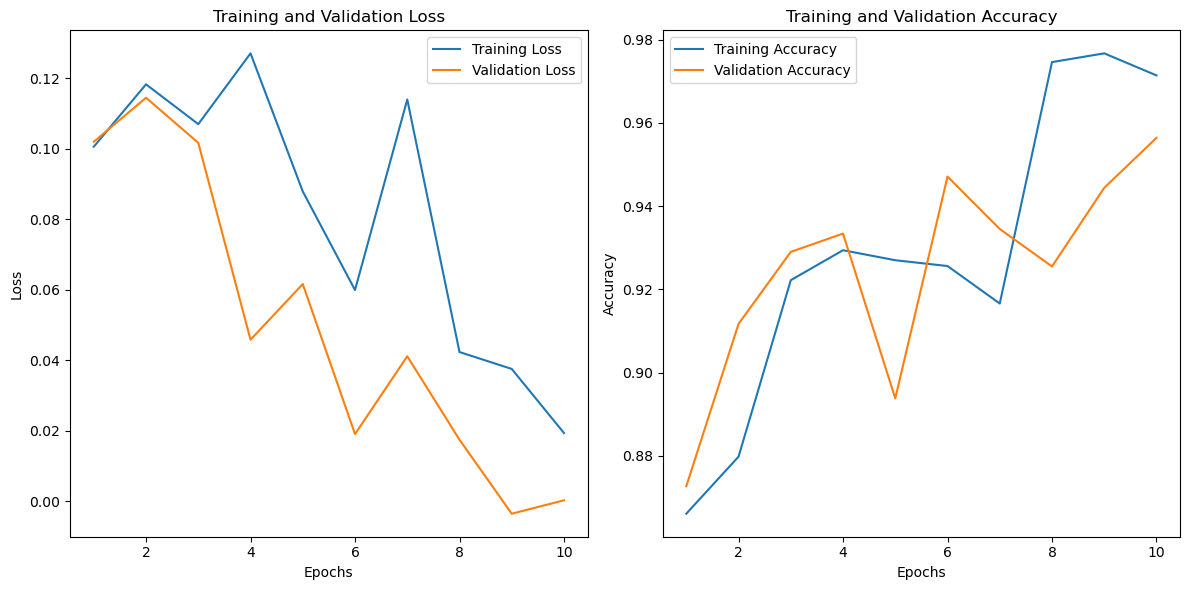

In [75]:
import matplotlib.pyplot as plt
history_dict = history.history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
loss, accuracy = model.evaluate(X_test,y_test)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Loss: 0.0923
Accuracy: 0.9446


## LLM model with Preprocessing

In [8]:
df = pd.read_csv('preprocessed.csv')

# Convert lists to strings
df['Encoded_Content'] = df['Encoded_Content'].apply(lambda x: ' '.join(eval(x)))

df['Encoded_Content'] = df['Encoded_Content'].astype(str).fillna(' ')
texts = df['Encoded_Content'].values
labels = df['Label'].values
texts = texts.tolist()
labels = labels.tolist()

x_temp, x_test, y_temp, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
x_train_texts, x_val_texts, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2


In [101]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='tf')

train_encodings = tokenize_texts(x_train_texts)
val_encodings = tokenize_texts(x_val_texts)
test_encodings = tokenize_texts(x_test)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_val))

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(16)
val_dataset = val_dataset.batch(16)
test_dataset = val_dataset.batch(16)
print(train_dataset)

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [96]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
11023/11023 [==============================] - 824s 32ms/step - loss: 0.1908 - accuracy: 0.9061 - val_loss: 0.1733 - val_accuracy: 0.8992
Epoch 2/10
11023/11023 [==============================] - 824s 32ms/step - loss: 0.1564 - accuracy: 0.9137 - val_loss: 0.1555 - val_accuracy: 0.8951
Epoch 3/10
11023/11023 [==============================] - 824s 32ms/step - loss: 0.1460 - accuracy: 0.9290 - val_loss: 0.1383 - val_accuracy: 0.9153
Epoch 4/10
11023/11023 [==============================] - 824s 32ms/step - loss: 0.1174 - accuracy: 0.9356 - val_loss: 0.1116 - val_accuracy: 0.9261
Epoch 5/10
11023/11023 [==============================] - 824s 32ms/step - loss: 0.1145 - accuracy: 0.9482 - val_loss: 0.0866 - val_accuracy: 0.9336
Epoch 6/10
11023/11023 [==============================] - 824s 32ms/step - loss: 0.0774 - accuracy: 0.9488 - val_loss: 0.0816 - val_accuracy: 0.9474
Epoch 7/10
11023/11023 [==============================] - 824s 32ms/step - loss: 0.0677 - accuracy: 0.9492

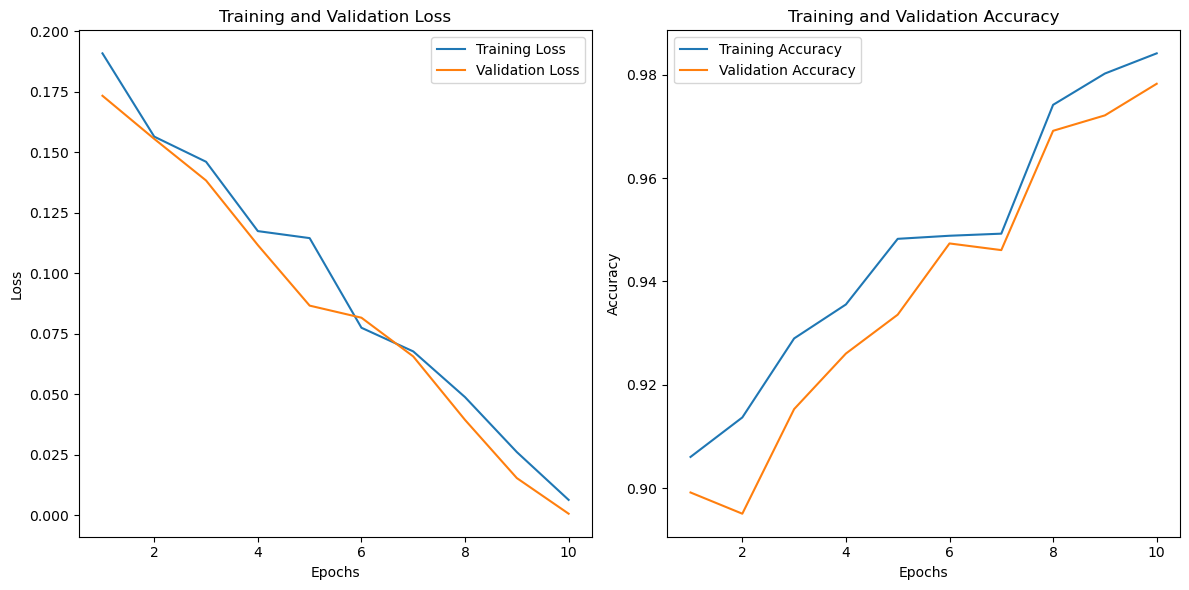

In [98]:
history_dict = history.history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [93]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Loss: 0.0032
Accuracy: 0.9862
